Paper Trading
* [Alpaca](https://app.alpaca.markets/signup)
* [QuantConnect](https://www.quantconnect.com)

# Import Libraries

In [1]:
# Web Scraping
from bs4 import BeautifulSoup
from lxml import html
import requests


# NLP
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from contractions import CONTRACTION_MAP
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize
# nltk.download('punkt')
from nltk.tokenize import MWETokenizer # multi-word expression
from nltk.tag import pos_tag
# nltk.download('averaged_perceptron_tagger')
# nltk.download('tagsets')

from gensim import corpora, models, similarities, matutils
import spacy
#python -m spacy download en_core_web_md
import en_core_web_md
import langdetect
nlp = en_core_web_md.load(parse=True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
#nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list+=['crypto','Crypto' 'cryptocurrencie', 'cryptocurrencies', 'Cryptocurrencies', 
                'cryptocurrency','Cryptocurrency', 'btc','Bitcoin','bitcoin','cryptocryptocurrencie']

# stopword_list.remove('no')
# stopword_list.remove('not')
from sklearn.decomposition import NMF
from spacy import displacy
#!pip install vaderSentiment 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Tools
import string
from datetime import date,timedelta,datetime
import unicodedata
import time
import re
import os
import pandas as pd
import numpy as np
import pickle
import random
from tqdm import tqdm, trange,tqdm_notebook
from sklearn import preprocessing

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
#pd.reset_option('^display.', silent=True) #Resets all pandas options

# Modeling
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

C:\Users\matt\Anaconda3\envs\nlp\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Functions

#### Helper Functions

In [2]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))


# example) do not -> don't. I would -> I'd
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

# standardized into ASCII characters. example) converting é to e
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text 

# Special characters and symbols
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text


def normalize_corpus(corpus, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
#         # remove stopwords
#         if stopword_removal:
#             doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

# Scraping

#### Google News Scraping Function

In [3]:
# Load webpage's url and load it into soup
def load_soup(url):
    user_agent_list = [
       #Chrome
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
        'Mozilla/5.0 (Windows NT 5.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
        'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
         ]
    

    
    headers = {"User-Agent":random.choice(user_agent_list)}
    response = requests.get(url,headers=headers)
    page = response.text
    soup = BeautifulSoup(page, "lxml")
    return soup,response.status_code

def scrape_bitcoin_news_google(num_per_page=40):

    # Define start and end dates
    with open('pickles/df_news_processed.pkl', 'rb') as picklefile: 
        df_news_processed = pickle.load(picklefile) 
    start_date = max(df_news_processed['date'])+timedelta(days=1)
    end_date = date.today()
    
    # Create "pickles" folder if it's not there
    git_folder_location = os.path.abspath(os.path.dirname('bitcoin_trader'))
    if 'pickles' not in os.listdir(git_folder_location):
        !mkdir 'pickles'

    # already scraped (list from what's already saved in the folder)
    done_list = list(df_news_processed['date'].unique())
    if '.DS_Store' in done_list:
        done_list.remove('.DS_Store')
        
    # Empty lists for DataFrame
    publishers = []
    titles = []
    intros = []
    dates = []         
        
    # Using trange to have a progress bar to gauge scraping time
    for i in trange((end_date-start_date).days):    
        # Month, day, and year to be embedded into the url
        M=start_date.month
        D=start_date.day
        Y=start_date.year        
        
        # Load data
        base_url = 'https://www.google.com/search?q=cryptocurrency+or+bitcoin&num=40&rlz=1C5CHFA_enUS849US849&biw=573&bih=717&source=lnt&tbs=cdr%3A1%2Ccd_min%3A{}%2F{}%2F{}%2Ccd_max%3A{}%2F{}%2F{}&tbm=nws&num={}'
        url= base_url.format(M,D,Y,M,D,Y,num_per_page)
        soup,response_code = load_soup(url)
        if response_code !=200:
            print("Blacklisted...?")
            print(start_date)
            break
        time.sleep(random.randint(15,30)) # Randomely sleep to not get blacklisted

        # Append data to list
        publishers += [publisher.text for publisher in soup.find_all('div', attrs = {'class': 'pDavDe RGRr8e'})]
        titles += [title.text for title in soup.find_all('div', attrs = {'class': 'phYMDf nDgy9d'})]
        intros += [intro.text for intro in soup.find_all('div', attrs = {'class': 'eYN3rb'})]
        dates += [start_date]*len([intro.text for intro in soup.find_all('div', attrs = {'class': 'eYN3rb'})])

        # Move onto next day
        start_date+=timedelta(days=1)
        
    # Turn data into DataFrame
    df = pd.DataFrame({'date':dates,'publisher':publishers,'title':titles,'intro':intros})



    # Combine title & intro and Remove '\n' from corpus
    df['title_intro'] = (df['title']+'. '+df['intro']).apply(lambda x : x.replace('\n',''))

    # Detect language
    df['language'] = df['title_intro'].apply(lambda x : langdetect.detect(x)).copy()
    df = df[df['language']=='en']
    df.reset_index(drop=True,inplace=True)

    # Apply various NLP processes in 'normalize_corpus function'
    df['title_intro_clean']=normalize_corpus(df['title_intro'])

    # Replace stock specific terms for sentiment analysis
    pos_list = ['rally', 'bounce', 'bullish', 'bull']
    neg_list = ['bearish','bear','dip']

    # Vader Sentiment Polarity
    analyser = SentimentIntensityAnalyzer()
    scores_vader =[]
    scores_txtblob =[]
    for article in df['title_intro_clean']:
        for word in pos_list:
            article=article.replace(word,'good')
        for word in neg_list:
            article=article.replace(word,'bad')
        scores_vader.append(analyser.polarity_scores(article)['compound'])
        scores_txtblob.append(np.round(TextBlob(article).sentiment.polarity,4)) 
    df['final_sentiment'] = (np.array(scores_vader)+np.array(scores_txtblob))/2

    # Concat processed df and df_news_processed
    df_news_processed = pd.concat([df_news_processed,df],ignore_index=True,axis=0)
    df_news_processed.sort_values(by=['date'],inplace=True)
    df_news_processed.drop_duplicates(inplace=True)
    df_news_processed.reset_index(drop=True,inplace=True)

    with open('pickles/df_news_processed.pkl','wb') as picklefile:
        pickle.dump(df_news_processed,picklefile) 
    
    return df_news_processed
# Scrape bitcoin news data
def scrape_bitcoin_price(df):
    
    start_date = min(df['date'])
    start_date = start_date.strftime('%Y')+start_date.strftime('%m')+start_date.strftime('%d')
    end_date = max(df['date'])
    end_date = end_date.strftime('%Y')+end_date.strftime('%m')+end_date.strftime('%d')
    # Create "price_data" folder if it's not there
    git_folder_location = os.path.abspath(os.path.dirname('bitcoin_trader'))
#     if 'pickles' not in os.listdir(git_folder_location):
#         !mkdir pickles


    # Load data
    url = 'https://coinmarketcap.com/currencies/bitcoin/historical-data/?start={}&end={}'.format(start_date,end_date)
    soup,response_code = load_soup(url)
    # Check if data was loaded successfully
    if response_code !=200:
        print("Blacklisted...?")

    data = []
    # Find all table elements
    table = soup.find_all('tr', attrs = {'class': 'text-right'})
    for row in table:
        data.append(row.text.split('\n')[1:-1])

    # Create dataframe and convert columns to right data types
    df_price = pd.DataFrame(data,columns=['date','open','high','low','close','volume','market_cap'])
    df_price['date'] = df_price['date'].astype('datetime64[ns]') 
    df_price['open'] = df_price['open'].astype(float) 
    df_price['high'] = df_price['high'].astype(float) 
    df_price['low'] = df_price['low'].astype(float) 
    df_price['close'] = df_price['close'].astype(float) 
    df_price['volume'] = df_price['volume'].str.replace(',', '').astype(float)
    df_price['market_cap'] = df_price['market_cap'].str.replace(',', '').astype(float)
    df_price.sort_values(by=['date'],inplace=True)
    df_price.reset_index(drop=True,inplace=True)
    
    # get daily sentiment score by getting mean of sentiments & concat it with bitcoin price data
    df_daily = df.groupby(['date'], as_index=False).mean().copy()
    #print(df_daily)
    df_daily = pd.concat([df_daily,df_price[['open', 'high', 'low', 'close', 'volume', 'market_cap']]],axis=1)

    # Generate More Features
    df_daily['percent_change_volume'] = (df_daily['volume'].shift(1)-df_daily['volume'])/df_daily['volume'].shift(1)
    df_daily['percent_change_daily_open'] = (df_daily['open'].shift(1)-df_daily['open'])/df_daily['open'].shift(1)
    df_daily['percent_change_wkly_open'] = (df_daily['open'].rolling(7).mean().shift(1)-df_daily['open'].rolling(7).mean())/df_daily['open'].rolling(7).mean().shift(1)
    df_daily['percent_change_monthly_open'] = (df_daily['open'].rolling(28).mean().shift(1)-df_daily['open'].rolling(28).mean())/df_daily['open'].rolling(28).mean().shift(1)
    df_daily['percent_change_daily_close'] = (df_daily['close'].shift(1)-df_daily['close'])/df_daily['close'].shift(1)
    df_daily['percent_change_wkly_close'] = (df_daily['close'].rolling(7).mean().shift(1)-df_daily['close'].rolling(7).mean())/df_daily['close'].rolling(7).mean().shift(1)
    df_daily['daily_sentiment_change'] = (df_daily['final_sentiment'].shift(1)-df_daily['final_sentiment'])/df_daily['final_sentiment'].shift(1)
    df_daily['wkly_sentiment_change'] = (df_daily['final_sentiment'].rolling(7).mean().shift(1)-df_daily['final_sentiment'].rolling(7).mean())/df_daily['final_sentiment'].rolling(7).mean().shift(1)
    df_daily['2wk_sentiment_change'] = (df_daily['final_sentiment'].rolling(14).mean().shift(1)-df_daily['final_sentiment'].rolling(14).mean())/df_daily['final_sentiment'].rolling(14).mean().shift(1)
    df_daily['3wk_sentiment_change'] = (df_daily['final_sentiment'].rolling(21).mean().shift(1)-df_daily['final_sentiment'].rolling(21).mean())/df_daily['final_sentiment'].rolling(21).mean().shift(1)
    df_daily['4wk_sentiment_change'] = (df_daily['final_sentiment'].rolling(28).mean().shift(1)-df_daily['final_sentiment'].rolling(28).mean())/df_daily['final_sentiment'].rolling(28).mean().shift(1)
    df_daily['target_daily'] = df_daily['percent_change_daily_close'].shift(-1)
    df_daily.dropna(inplace=True)
    df_daily.reset_index(drop=True,inplace=True)

    # Pickle df_daily
    with open('pickles/df_daily.pkl','wb') as picklefile:
        pickle.dump(df_daily,picklefile)
        
    return df_daily

#### One Work Flow

In [4]:
df_news_processed = scrape_bitcoin_news_google()
# with open('df_news_processed.pkl','wb') as picklefile:
#     pickle.dump(df_news_processed,picklefile)
# with open('df_news_processed.pkl','rb') as picklefile:
#     df_news_processed = pickle.load(picklefile)
df_daily = scrape_bitcoin_price(df_news_processed)
# # Load df_news_clean
# with open('pickles/df_daily.pkl', 'rb') as picklefile: 
#     df_daily = pickle.load(picklefile)
    

0it [00:00, ?it/s]


In [167]:
# # Add LDA Features 

# from gensim.corpora import Dictionary
# dic = Dictionary([df_news_processed['title_intro_clean']])
# vec_bows=[]
# for ix,item in enumerate(corpus):
#     vec_bows.append(item)

# vec_lda_topics=[lda[vec_bow] for vec_bow in vec_bows]

# lda_vector = []
# for id,vec_lda_topic in enumerate(vec_lda_topics):
#     lda_vector.append(vec_lda_topic)
    
# num_topic = 13
# lda_topic_vectors = []
# for vector in lda_vector:
#     empty_dict = {x:0 for x in range(num_topic)}
#     for topic in vector:            
#         empty_dict[topic[0]]=topic[1]
#     lda_topic_vectors.append(list(empty_dict.values()))
    
# # Create DF of lda topic vectors and turn it groupby date
# df_lda = pd.DataFrame(lda_topic_vectors)
# df_lda['date'] = df_news_processed['date']
# df_lda_daily = df_lda.groupby(by=['date'],as_index=False,).mean()

# # Merge lda vector to main dataframe
# df_daily = df_daily.merge(df_lda_daily, left_on='date', right_on='date')

# Topic Modeling

#### Tf-idf & LDA <- Use This

###### Model

In [654]:
# new TF-IDF Vectorizer
cv_tfidf = TfidfVectorizer(stop_words=stopword_list,max_df=0.08,min_df=0.004)
# cv_tfidf = TfidfVectorizer(stop_words=stopword_list,max_df=0.6,min_df=0.005,ngram_range=(1, 2))
doc_word = cv_tfidf.fit_transform(df_news_processed['title_intro_clean'])

print(doc_word.shape)

# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(doc_word.transpose())

# We need to save a mapping (dict) of row id to word (token) for later use by gensim:
id2word = dict((v, k) for k, v in cv_tfidf.vocabulary_.items())

# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaMulticore(corpus=corpus, num_topics=13, id2word=id2word, passes=5, workers=1)

# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]

# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

# View Topic Distribution
doc_cluster = [sorted(doc,key=lambda row:row[1])[::-1][0][0] for doc in lda_docs]
# sns.barplot(x=pd.Series(doc_cluster).value_counts().keys(),y=pd.Series(doc_cluster).value_counts().values);

# # Check out the document vectors in the topic space for the first 5 documents
# lda_docs[:5]
# lda.print_topics()

# #Save Trained Model
# with open('lda.pkl', 'wb') as picklefile:
#     pickle.dump(lda, picklefile)   

##### Identify Topics

In [643]:
topic_mapping={
                0:'Cryptocurrency Mining',
                1:'Tax Related',
                2:'Technology',
                3:'Binance - Biggest Crypto Trading Platform',
                4:'Market Analysis',
                5:'International - China and India',
                6:'Hackers/Stealing'  ,
                7:'Venezuela and Cryptocurrency', #Venezuela has hyperinflation with national currency. People ruf off to cryptos
                8:'Market',
                9:'Different Cryptocurrencies',
                10:'Satoshi Nakamoto',
                11:'Facebook',
                12:'Regulations'}

##### Update df_news_clean dataframe with classified topics and pickle it

In [648]:
df_topics = []
for vec in vec_topics:
    sorted_x = sorted(vec, key=operator.itemgetter(1))
    sorted_x.reverse()
    df_topics.append(topic_mapping[sorted_x[0][0]])
with open('df_news_clean_topic.pkl','wb') as picklefile:
    pickle.dump(df_news_clean,picklefile)

NameError: name 'vec_topics' is not defined

# Sentiment Analysis

#### Functions Threshold Finding and Graphing Profits

In [5]:
def best_threshold2(df,min_threshold,max_threshold,step,min_date,max_date):
    
    # Add all final profit later on to these empty lists
    thresholds,senti_change_daily,senti_change_weekly,senti_change_2wk,senti_change_monthly = [],[],[],[],[]
    threshold_list = np.arange(min_threshold,max_threshold,step)
    for i in range(len(threshold_list)):
        positive_sentiment_threshold = threshold_list[i]


        # Mask to limit daterange for searching best threshhold
        mask = ((df['date']>min_date)&(df['date']<max_date))
        df = df[mask].copy()

        df['compound_change_buy_sell_daily'] = df['daily_sentiment_change'].apply(lambda x: 1 if x>positive_sentiment_threshold else 0).copy()
        df['compound_change_profit_daily'] = (df['compound_change_buy_sell_daily']*100*df['target_daily']).copy()        
        
        df['compound_change_buy_sell_wkly'] = df['wkly_sentiment_change'].apply(lambda x: 1 if x>positive_sentiment_threshold else 0).copy()
        df['compound_change_profit_wkly'] = (df['compound_change_buy_sell_wkly']*100*df['target_daily']).copy()

        df['compound_change_buy_sell_2wk'] = df['2wk_sentiment_change'].apply(lambda x: 1 if x>positive_sentiment_threshold else 0).copy()
        df['compound_change_profit_2wk'] = (df['compound_change_buy_sell_2wk']*100*df['target_daily']).copy()

        df['compound_change_buy_sell_4wk'] = df['4wk_sentiment_change'].apply(lambda x: 1 if x>positive_sentiment_threshold else 0).copy()
        df['compound_change_profit_monthly'] = (df['compound_change_buy_sell_4wk']*100*df['target_daily']).copy()

        # Drop NAs
        df.dropna(inplace=True)

        # Get Cumulative Profits
        compound_change_profit_daily = list(df['compound_change_profit_daily'])
        compound_change_profit_wkly = list(df['compound_change_profit_wkly'])
        compound_change_profit_2wk = list(df['compound_change_profit_2wk'])
        compound_change_profit_monthly = list(df['compound_change_profit_monthly'])

        for i in range(1,len(compound_change_profit_daily)):
            compound_change_profit_daily[i] = compound_change_profit_daily[i]+compound_change_profit_daily[i-1] 
        for i in range(1,len(compound_change_profit_wkly)):
            compound_change_profit_wkly[i] = compound_change_profit_wkly[i]+compound_change_profit_wkly[i-1]            
        for i in range(1,len(compound_change_profit_2wk)):
            compound_change_profit_2wk[i] = compound_change_profit_2wk[i]+compound_change_profit_2wk[i-1]  
        for i in range(1,len(compound_change_profit_monthly)):
            compound_change_profit_monthly[i] = compound_change_profit_monthly[i]+compound_change_profit_monthly[i-1] 

        thresholds.append(positive_sentiment_threshold)
        senti_change_daily.append(compound_change_profit_daily[-1])
        senti_change_weekly.append(compound_change_profit_wkly[-1])
        senti_change_2wk.append(compound_change_profit_2wk[-1])
        senti_change_monthly.append(compound_change_profit_monthly[-1])
    return thresholds,senti_change_daily,senti_change_weekly,senti_change_2wk,senti_change_monthly
# Get profit based on model's predictions. Punish it if it predicted to buy but actually it was a loss. Else, no action = profit = 0.
def model_profit_graph(df,min_date,max_date,max_max_date,threshold,graph_model_T_F,model_output):
    
    if threshold=='dynamic':
        # Get Cumulative Profit for Generic Models       
        thresholds,senti_change_daily,senti_change_weekly,senti_change_2wk,senti_change_monthly = best_threshold2(df,0,0.3,0.002,min_date,max_date)
        best_threshold_daily = thresholds[np.argmax(senti_change_daily)]
        best_threshold_weekly = thresholds[np.argmax(senti_change_weekly)]
        best_threshold_biweekly = thresholds[np.argmax(senti_change_2wk)]
        best_threshold_monthly = thresholds[np.argmax(senti_change_monthly)]

        mask = ((df['date']>max_date)&(df['date']<max_max_date))
        df = df[mask]
        df['daily_buy_sell'] = df['wkly_sentiment_change'].apply(lambda x: 1 if x>best_threshold_daily else 0).copy()
        df['daily_profit'] = (df['daily_buy_sell']*100*df['target_daily']).copy()
        df['weekly_buy_sell'] = df['wkly_sentiment_change'].apply(lambda x: 1 if x>best_threshold_weekly else 0).copy()
        df['weekly_profit'] = (df['weekly_buy_sell']*100*df['target_daily']).copy()
        df['biweekly_buy_sell'] = df['2wk_sentiment_change'].apply(lambda x: 1 if x>best_threshold_biweekly else 0).copy()
        df['biweekly_profit'] = (df['biweekly_buy_sell']*100*df['target_daily']).copy()
        df['monthly_buy_sell'] = df['4wk_sentiment_change'].apply(lambda x: 1 if x>best_threshold_monthly else 0).copy()
        df['monthly_profit'] = (df['monthly_buy_sell']*100*df['target_daily']).copy()
        df.dropna(inplace=True)
    else :
        # Get Cumulative Profit for Generic Models       
        best_threshold_daily = threshold
        best_threshold_weekly = threshold
        best_threshold_biweekly = threshold
        best_threshold_monthly = threshold

        
        mask = ((df['date']>max_date)&(df['date']<max_max_date))
        df = df[mask]
        df['daily_buy_sell'] = df['wkly_sentiment_change'].apply(lambda x: 1 if x>best_threshold_daily else 0).copy()
        df['daily_profit'] = (df['daily_buy_sell']*100*df['target_daily']).copy()
        df['weekly_buy_sell'] = df['wkly_sentiment_change'].apply(lambda x: 1 if x>best_threshold_weekly else 0).copy()
        df['weekly_profit'] = (df['weekly_buy_sell']*100*df['target_daily']).copy()
        df['biweekly_buy_sell'] = df['2wk_sentiment_change'].apply(lambda x: 1 if x>best_threshold_biweekly else 0).copy()
        df['biweekly_profit'] = (df['biweekly_buy_sell']*100*df['target_daily']).copy()
        df['monthly_buy_sell'] = df['4wk_sentiment_change'].apply(lambda x: 1 if x>best_threshold_monthly else 0).copy()
        df['monthly_profit'] = (df['monthly_buy_sell']*100*df['target_daily']).copy()        

        
    daily_profit = list(df['daily_profit'])
    for i in range(1,len(daily_profit)):
        daily_profit[i] = daily_profit[i]+daily_profit[i-1] 
    weekly_profit = list(df['weekly_profit'])
    for i in range(1,len(weekly_profit)):
        weekly_profit[i] = weekly_profit[i]+weekly_profit[i-1]        
    biweekly_profit = list(df['biweekly_profit'])
    for i in range(1,len(biweekly_profit)):
        biweekly_profit[i] = biweekly_profit[i]+biweekly_profit[i-1]        
    monthly_profit = list(df['monthly_profit'])
    for i in range(1,len(monthly_profit)):
        monthly_profit[i] = monthly_profit[i]+monthly_profit[i-1]

        
            
    # Get ideal profit for the same day if you bought $100 worth of bitcoin in one day and sold it exactly day after
    df['target_daily_profit'] = df['target_daily'].apply(lambda x: 100*x if x>0 else 0)  
    # Gain cumulative profit
    target_profit = list(df['target_daily_profit'])
    for i in range(1,len(target_profit)):
        target_profit[i] = (target_profit[i]+target_profit[i-1])
    plt.figure(figsize=(15,8))  
    sns.lineplot(x=df['date'],y=target_profit)  
    if graph_model_T_F==True:        
        # Get Cumulative Profit for LightGBM
        df['pred'] = model_output   
        pred_profit = []
        for i in range(len(df['pred'])):
            if (df['pred'].iloc[i]>0):
                pred_profit.append(df['target_daily'].iloc[i]*100)
            else:
                pred_profit.append(0) 
        
        target_profit = list(df['target_daily_profit'])
        for i in range(1,len(target_profit)):
            target_profit[i] = (target_profit[i]+target_profit[i-1])
            pred_profit[i] = (pred_profit[i]+pred_profit[i-1])       
        
        sns.lineplot(x=df['date'],y=pred_profit)
#    print("Best Case : ${}".format(np.round(target_profit[-1],2)) )  
#     if graph_model_T_F==True: 
#         print("Model Profit : ${} ({}%)".format(np.round(pred_profit[-1],2), np.round(pred_profit[-1]/target_profit[-1]*100,2)  ))
#     print("Daily Profit : ${} ({}%)".format(np.round(daily_profit[-1],2), np.round(daily_profit[-1]/target_profit[-1]*100,2)  ))
#     print("Weekly Profit : ${} ({}%)".format(np.round(weekly_profit[-1],2), np.round(weekly_profit[-1]/target_profit[-1]*100,2)  ))
#     print("Biweekly Profit : ${} ({}%)".format(np.round(biweekly_profit[-1],2), np.round(biweekly_profit[-1]/target_profit[-1]*100,2)  ))
#     print("Monthly Profit : ${} ({}%)".format(np.round(monthly_profit[-1],2), np.round(monthly_profit[-1]/target_profit[-1]*100,2)  ))
     
    # Plot cumulative profit

    sns.lineplot(x=df['date'],y=daily_profit)
    sns.lineplot(x=df['date'],y=weekly_profit)
    sns.lineplot(x=df['date'],y=biweekly_profit)
    sns.lineplot(x=df['date'],y=monthly_profit)
   
    plt.axhline(y=0,color='r',linestyle ='-.' )  #vertical line. Linestype : ['-', '--', '-.', ':', '',]

    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel("Profit ($)")
    plt.title('Cumulative Profit')
    if graph_model_T_F==True:
        plt.legend([ 'Actual - ${}'.format(np.round(target_profit[-1],2)),
                     'Trading Bot - ${} ({}%)'.format(np.round(pred_profit[-1],2), np.round(pred_profit[-1]/target_profit[-1]*100,2)),
                     'Daily Sentiment MA ({})- ${} ({}%)'.format(np.round(best_threshold_daily,4),np.round(daily_profit[-1],2), np.round(daily_profit[-1]/target_profit[-1]*100,2)),
                     'Weekly Sentiment MA ({})- ${} ({}%)'.format(np.round(best_threshold_weekly,4),np.round(weekly_profit[-1],2), np.round(weekly_profit[-1]/target_profit[-1]*100,2)  ),
                     'Bi-weekly Sentiment MA ({})- ${} ({}%)'.format(np.round(best_threshold_biweekly,4),np.round(biweekly_profit[-1],2), np.round(biweekly_profit[-1]/target_profit[-1]*100,2)  ),
                     'Monthly Sentiment MA ({})- ${} ({}%)'.format(np.round(best_threshold_monthly,4),np.round(monthly_profit[-1],2), np.round(monthly_profit[-1]/target_profit[-1]*100,2)   )])
    else:plt.legend(['Actual - ${}'.format(np.round(target_profit[-1],2)),
                     'Daily Sentiment MA ({})- ${} ({}%)'.format(np.round(best_threshold_daily,4),np.round(daily_profit[-1],2), np.round(daily_profit[-1]/target_profit[-1]*100,2)  ),
                     'Weekly Sentiment MA ({})- ${} ({}%)'.format(np.round(best_threshold_weekly,4),np.round(weekly_profit[-1],2), np.round(weekly_profit[-1]/target_profit[-1]*100,2)  ),
                     'Bi-weekly Sentiment MA ({})- ${} ({}%)'.format(np.round(best_threshold_biweekly,4),np.round(biweekly_profit[-1],2), np.round(biweekly_profit[-1]/target_profit[-1]*100,2)   ),
                     'Monthly Sentiment MA ({})- ${} ({}%)'.format(np.round(best_threshold_monthly,4),np.round(monthly_profit[-1],2), np.round(monthly_profit[-1]/target_profit[-1]*100,2)   )])
    #plt.grid()
    plt.show()

In [6]:
def model_profit_moving(df,min_date,max_date,max_max_date,threshold,graph_model_T_F,model_output):
    
    if threshold=='dynamic':
        # Get Cumulative Profit for Generic Models       
        thresholds,senti_change_daily,senti_change_weekly,senti_change_2wk,senti_change_monthly = best_threshold2(df,0,0.3,0.002,min_date,max_date)
        best_threshold_daily = thresholds[np.argmax(senti_change_daily)]
        best_threshold_weekly = thresholds[np.argmax(senti_change_weekly)]
        best_threshold_biweekly = thresholds[np.argmax(senti_change_2wk)]
        best_threshold_monthly = thresholds[np.argmax(senti_change_monthly)]

        mask = ((df['date']>max_date)&(df['date']<max_max_date))
        df = df[mask]
        df['daily_buy_sell'] = df['wkly_sentiment_change'].apply(lambda x: 1 if x>best_threshold_daily else 0).copy()
        df['daily_profit'] = (df['daily_buy_sell']*100*df['target_daily']).copy()
        df['weekly_buy_sell'] = df['wkly_sentiment_change'].apply(lambda x: 1 if x>best_threshold_weekly else 0).copy()
        df['weekly_profit'] = (df['weekly_buy_sell']*100*df['target_daily']).copy()
        df['biweekly_buy_sell'] = df['2wk_sentiment_change'].apply(lambda x: 1 if x>best_threshold_biweekly else 0).copy()
        df['biweekly_profit'] = (df['biweekly_buy_sell']*100*df['target_daily']).copy()
        df['monthly_buy_sell'] = df['4wk_sentiment_change'].apply(lambda x: 1 if x>best_threshold_monthly else 0).copy()
        df['monthly_profit'] = (df['monthly_buy_sell']*100*df['target_daily']).copy()
        df.dropna(inplace=True)
    else :
        # Get Cumulative Profit for Generic Models       
        best_threshold_daily = threshold
        best_threshold_weekly = threshold
        best_threshold_biweekly = threshold
        best_threshold_monthly = threshold

        
        mask = ((df['date']>max_date)&(df['date']<max_max_date))
        df = df[mask]
        df['daily_buy_sell'] = df['wkly_sentiment_change'].apply(lambda x: 1 if x>best_threshold_daily else 0).copy()
        df['daily_profit'] = (df['daily_buy_sell']*100*df['target_daily']).copy()
        df['weekly_buy_sell'] = df['wkly_sentiment_change'].apply(lambda x: 1 if x>best_threshold_weekly else 0).copy()
        df['weekly_profit'] = (df['weekly_buy_sell']*100*df['target_daily']).copy()
        df['biweekly_buy_sell'] = df['2wk_sentiment_change'].apply(lambda x: 1 if x>best_threshold_biweekly else 0).copy()
        df['biweekly_profit'] = (df['biweekly_buy_sell']*100*df['target_daily']).copy()
        df['monthly_buy_sell'] = df['4wk_sentiment_change'].apply(lambda x: 1 if x>best_threshold_monthly else 0).copy()
        df['monthly_profit'] = (df['monthly_buy_sell']*100*df['target_daily']).copy()        

        
    daily_profit = list(df['daily_profit'])
    for i in range(1,len(daily_profit)):
        daily_profit[i] = daily_profit[i]+daily_profit[i-1] 
    weekly_profit = list(df['weekly_profit'])
    for i in range(1,len(weekly_profit)):
        weekly_profit[i] = weekly_profit[i]+weekly_profit[i-1]        
    biweekly_profit = list(df['biweekly_profit'])
    for i in range(1,len(biweekly_profit)):
        biweekly_profit[i] = biweekly_profit[i]+biweekly_profit[i-1]        
    monthly_profit = list(df['monthly_profit'])
    for i in range(1,len(monthly_profit)):
        monthly_profit[i] = monthly_profit[i]+monthly_profit[i-1]

        
            
    # Get ideal profit for the same day if you bought $100 worth of bitcoin in one day and sold it exactly day after
    df['target_daily_profit'] = df['target_daily'].apply(lambda x: 100*x if x>0 else 0)  
    # Gain cumulative profit
    target_profit = list(df['target_daily_profit'])
    for i in range(1,len(target_profit)):
        target_profit[i] = (target_profit[i]+target_profit[i-1])

    if graph_model_T_F==True:        
        # Get Cumulative Profit for LightGBM
        df['pred'] = model_output   
        pred_profit = []
        for i in range(len(df['pred'])):
            if (df['pred'].iloc[i]>0):
                pred_profit.append(df['target_daily'].iloc[i]*100)
            else:
                pred_profit.append(0) 
        
        target_profit = list(df['target_daily_profit'])
        for i in range(1,len(target_profit)):
            target_profit[i] = (target_profit[i]+target_profit[i-1])
            pred_profit[i] = (pred_profit[i]+pred_profit[i-1])       

    if graph_model_T_F==True: 
        print("Model Profit : ${}".format(np.round(pred_profit[-1],2) ))

    return (max_date,max_max_date), np.round(target_profit[-1],2),np.round(daily_profit[-1],2),np.round(weekly_profit[-1],2),np.round(biweekly_profit[-1],2),np.round(monthly_profit[-1],2),np.round(pred_profit[-1],2)


#  LSTM

In [7]:
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, BatchNormalization, Activation, Bidirectional
from keras.models import Sequential
import tensorflow as tf

from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import logging
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


#### Fucntions

In [294]:
def custom_train_test_split(df, train_cols,date_gap, min_date,max_date,max_max_date):
    from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

    # 2018.6 Market stabilized 
    min_date = min_date
    max_date = max_date
    max_max_date = max_max_date
    
    mask_train = ((df['date']>min_date)  & (df['date']<(max_date- timedelta(days=date_gap))))
    mask_test = ((df['date'] > max_date) & (df['date'] < max_max_date))

    df_train = df[mask_train]
    df_test  = df[mask_test]

    print("Train and Test size", len(df_train), len(df_test))
    # scale the feature MinMax, build array
    x = df_train.loc[:,train_cols].values
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x)
    x_test = scaler.transform(df_test.loc[:,train_cols]) 
    return x_train, x_test, scaler

# TIME_STEPS is how many units back in time you want your network to see
def build_timeseries(mat,TIME_STEPS, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

# Small batch_size increase train time and too big batch size reduce model's ability to generalize, but quicker
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat
# Use of return_sequences : https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/
def create_model(lr):
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(128, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, #return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
#     lstm_model.add(LSTM(60, dropout=0.0))
#     lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(16,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=lr)
    #optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model

#### Test

In [296]:
# Parameters for train/test split
min_date = date(2014,6,1)
max_date = date(2019,3,1)
date_gap = 8
max_max_date = date(2020,1,1)
train_cols = [
              'final_sentiment','open','high', 'low', 'close', 'volume','market_cap',
             'percent_change_volume','percent_change_daily_close','daily_sentiment_change',
              'percent_change_wkly_close','wkly_sentiment_change'
             ]
x_train, x_test, scaler = custom_train_test_split(df_daily,train_cols,date_gap, min_date,max_date,max_max_date )

# Parameters for processing data for LSTM input
BATCH_SIZE = 8 # Small batch_size increase train time and too big batch size reduce model's ability to generalize, but quicker
TIME_STEPS = 28 # how far it looks back
y_col_index = np.where(np.array(train_cols) == 'close')[0][0]

x_t, y_t = build_timeseries(x_train, TIME_STEPS, y_col_index)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test,TIME_STEPS, y_col_index)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

# Start LSTM Model & Train
lstm_model = create_model(0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='auto',restore_best_weights=True)
callbacks_list = [early_stopping]

history = lstm_model.fit(x_t, y_t, epochs=200, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)), callbacks=callbacks_list)

Train and Test size 845 175



length of time-series i/o (817, 28, 12) (817,)



length of time-series i/o (147, 28, 12) (147,)
Train on 816 samples, validate on 72 samples
Epoch 1/200
 - 12s - loss: 0.0658 - val_loss: 0.0248
Epoch 2/200
 - 1s - loss: 0.0124 - val_loss: 0.0248
Epoch 3/200
 - 1s - loss: 0.0069 - val_loss: 0.0127
Epoch 4/200
 - 1s - loss: 0.0054 - val_loss: 0.0093
Epoch 5/200
 - 1s - loss: 0.0045 - val_loss: 0.0054
Epoch 6/200
 - 1s - loss: 0.0041 - val_loss: 0.0039
Epoch 7/200
 - 1s - loss: 0.0038 - val_loss: 0.0054
Epoch 8/200
 - 1s - loss: 0.0034 - val_loss: 0.0050
Epoch 9/200
 - 1s - loss: 0.0030 - val_loss: 0.0036
Epoch 10/200
 - 1s - loss: 0.0028 - val_loss: 0.0036
Epoch 11/200
 - 1s - loss: 0.0027 - val_loss: 0.0040
Epoch 12/200
 - 1s - loss: 0.0025 - val_loss: 0.0036
Epoch 13/200
 - 1s - loss: 0.0024 - val_loss: 0.0036
Epoch 14/200
 - 1s - loss: 0.0022 - val_loss: 0.0041
Epoch 15/200
 - 1s - loss: 0.0020 - val_loss: 0.0020
Epoch 16/200
 - 1s - loss: 0.0021 - val_loss: 0.0027
Epoch 17/200
 - 1s - loss: 0.0021 - val_loss: 0.0022
Epoch 18/200
 

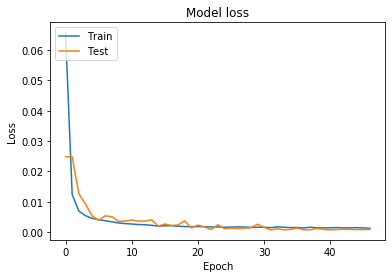

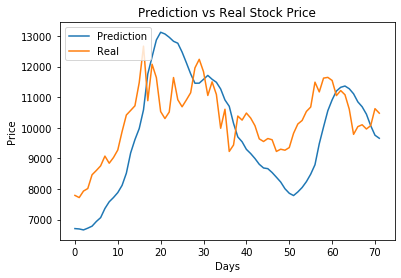

In [297]:
# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
#plt.savefig(os.path.join(git_folder_location, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))

# load the saved best model from above
# saved_model = load_model(os.path.join(git_folder_location, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
# print(saved_model)

y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
# error = mean_squared_error(y_test_t, y_pred)
# print("Error is", error, y_pred.shape, y_test_t.shape)
# print(y_pred[0:15])
# print(y_test_t[0:15])
y_pred_org = (y_pred * scaler.data_range_[3]) + scaler.data_min_[3] # scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * scaler.data_range_[3]) + scaler.data_min_[3] # scaler.inverse_transform(y_test_t)
# print(y_pred_org[0:15])
# print(y_test_t_org[0:15])

# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
#plt.savefig(os.path.join(git_folder_location, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
#print_time("program completed ", stime)
# No sentiment